In [2]:
import os
import pandas as pd


In [3]:
shot_df = pd.read_csv("shots.csv")

In [4]:
three_point_shots = shot_df[shot_df["THREE"] == True]
three_point_shots["Made"] = (three_point_shots["CHANCE_PTS_SCORED"] > 0).astype(int)

<ipython-input-4-5080c2a0bf32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_point_shots["Made"] = (three_point_shots["CHANCE_PTS_SCORED"] > 0).astype(int)


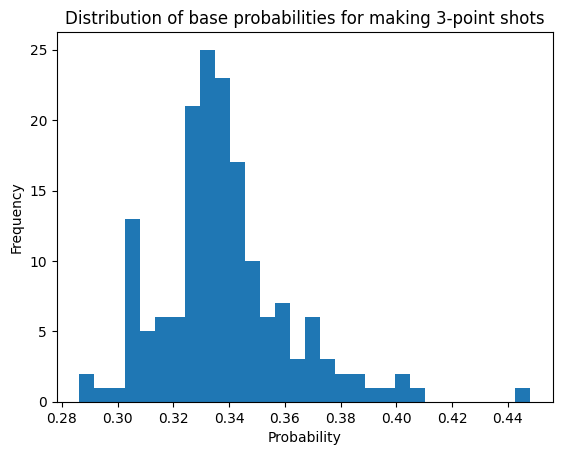

'\nprint("Posterior predictive means: ")\nprint([n.mean() for n in ppc["posterior_predictive"]["y"]])\nprint("Observed mean: ")\nprint(three_point_shots["Made"].mean())\n'

In [5]:
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

three_point_shots = three_point_shots.sort_values(by=["OPLAYER_ID_SS"])
three_point_shots = three_point_shots.iloc[0:int(.25 * len(three_point_shots))]

player_ids = three_point_shots["OPLAYER_ID_SS"].astype(str)
n_players = len(np.unique(player_ids))
player_index = pd.Categorical(player_ids).codes

#Standardize distances to nearest defender
scaler = StandardScaler()
three_point_shots["ScaledDistance"] = scaler.fit_transform(three_point_shots["SHOT_DPLAYER_CLOSEST_DIST"].to_numpy().reshape(-1, 1))

with pm.Model() as model:

  #Group hyperparams
  mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=1)
  sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)

  #Player-specific params
  alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_players)

  #Coefficient for nearest defender distance
  beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)

  #Likelihood
  p = pm.math.invlogit(alpha[player_index] + beta_distance * three_point_shots["ScaledDistance"])
  y = pm.Bernoulli('y', p=p, observed=three_point_shots['Made'].values)

  trace = pm.sample(500, return_inferencedata=False)

  ppc = pm.sample_posterior_predictive(trace, var_names='y')

alpha_mean = trace['alpha'].mean(axis=0)
beta_distance_mean = trace["beta_distance"].mean()
base_probabilities = 1 / (1 + np.exp(-(alpha_mean + beta_distance_mean * 0)))

#Collect into dataframe
player_probabilities = pd.DataFrame({
    "PlayerId": np.unique(player_ids),
    "BaseProbability": base_probabilities
})

plt.hist(base_probabilities, bins=30)
plt.title('Distribution of base probabilities for making 3-point shots')
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

"""
print("Posterior predictive means: ")
print([n.mean() for n in ppc["posterior_predictive"]["y"]])
print("Observed mean: ")
print(three_point_shots["Made"].mean())
"""

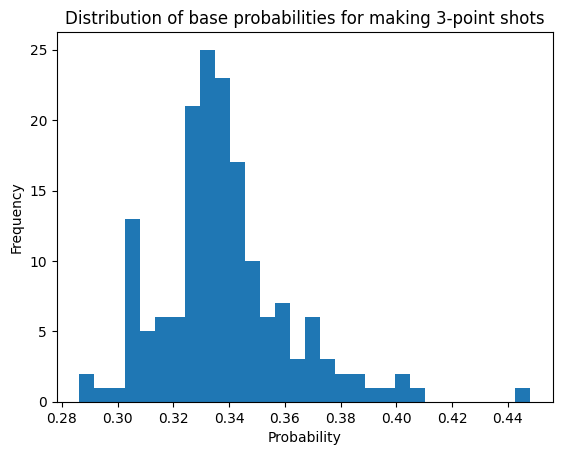

'\nprint("Posterior predictive means: ")\nprint([n.mean() for n in ppc["posterior_predictive"]["y"]])\nprint("Observed mean: ")\nprint(three_point_shots["Made"].mean())\n'

In [6]:
alpha_mean = trace['alpha'].mean(axis=0)
beta_distance_mean = trace["beta_distance"].mean()
base_probabilities = 1 / (1 + np.exp(-(alpha_mean + beta_distance_mean * 0)))

#Collect into dataframe
player_probabilities = pd.DataFrame({
    "PlayerId": np.unique(player_ids),
    "BaseProbability": base_probabilities
})

plt.hist(base_probabilities, bins=30)
plt.title('Distribution of base probabilities for making 3-point shots')
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

"""
print("Posterior predictive means: ")
print([n.mean() for n in ppc["posterior_predictive"]["y"]])
print("Observed mean: ")
print(three_point_shots["Made"].mean())
"""

In [7]:
player_probabilities["OPLAYER_ID_SS"] = player_probabilities["PlayerId"]

In [8]:
player_summary = three_point_shots.groupby(["OPLAYER_ID_SS", "OPLAYER_FULL_NAME"]).agg(
    TotalAttempts=("OPLAYER_ID_SS", 'count'),
    TotalMakes=("Made", "sum")
).reset_index()

probs = pd.merge(player_probabilities, player_summary, on="OPLAYER_ID_SS", how="inner")

In [9]:
stable_vol = 750
mean_3p = .356
probs["PaddedProbabilities"] = (probs["TotalMakes"] + stable_vol * mean_3p) / (probs["TotalAttempts"] + stable_vol)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
probs["ScaledAttempts"] = scaler.fit_transform(probs[["TotalAttempts"]])

In [11]:
probs["CombinedEstimate"] = probs["ScaledAttempts"] * probs["BaseProbability"] + (1 - probs["ScaledAttempts"])*probs["PaddedProbabilities"]

In [12]:
probs

,PlayerId,BaseProbability,OPLAYER_ID_SS,OPLAYER_FULL_NAME,TotalAttempts,TotalMakes,PaddedProbabilities,ScaledAttempts,CombinedEstimate
0,0000b397-3cf4-4dd4-a910-000000000131,0.300476,0000b397-3cf4-4dd4-a910-000000000131,Cody Martin,77,18,0.344619,0.098573,0.340268
1,00d15dc2-5027-4861-8534-08e6c4b68f45,0.329235,00d15dc2-5027-4861-8534-08e6c4b68f45,Juwan Morgan,18,5,0.354167,0.022049,0.353617
2,0217f93f-6328-45d4-8eb5-e7c99a5d8dac,0.343419,0217f93f-6328-45d4-8eb5-e7c99a5d8dac,Chris Chiozza,88,32,0.356802,0.112840,0.355292
3,039b64ee-ba67-4b53-9cf7-77704ef886e6,0.305874,039b64ee-ba67-4b53-9cf7-77704ef886e6,Malik Monk,197,55,0.340021,0.254215,0.331341
4,0511e7cf-e543-4547-aa9d-1c80e0ec3ad8,0.306850,0511e7cf-e543-4547-aa9d-1c80e0ec3ad8,Derrick Jones Jr.,142,42,0.346413,0.182879,0.339177
...,...,...,...,...,...,...,...,...,...
160,9508237c-85e2-4121-b4da-f11687f79fdf,0.303271,9508237c-85e2-4121-b4da-f11687f79fdf,Marquese Chriss,39,8,0.348542,0.049287,0.346311
161,96197493-27db-4925-bf19-90cacaac467b,0.331955,96197493-27db-4925-bf19-90cacaac467b,Frank Mason,21,6,0.354086,0.025940,0.353512
162,9703e798-53ed-483a-b30e-6fe843a9f2cb,0.332689,9703e798-53ed-483a-b30e-6fe843a9f2cb,Amir Coffey,20,6,0.354545,0.024643,0.354007
163,97557441-df62-4371-8720-66f68535b73c,0.306977,97557441-df62-4371-8720-66f68535b73c,Kenrich Williams,99,27,0.346290,0.127108,0.341293


In [13]:
probs

,PlayerId,BaseProbability,OPLAYER_ID_SS,OPLAYER_FULL_NAME,TotalAttempts,TotalMakes,PaddedProbabilities,ScaledAttempts,CombinedEstimate
0,0000b397-3cf4-4dd4-a910-000000000131,0.300476,0000b397-3cf4-4dd4-a910-000000000131,Cody Martin,77,18,0.344619,0.098573,0.340268
1,00d15dc2-5027-4861-8534-08e6c4b68f45,0.329235,00d15dc2-5027-4861-8534-08e6c4b68f45,Juwan Morgan,18,5,0.354167,0.022049,0.353617
2,0217f93f-6328-45d4-8eb5-e7c99a5d8dac,0.343419,0217f93f-6328-45d4-8eb5-e7c99a5d8dac,Chris Chiozza,88,32,0.356802,0.112840,0.355292
3,039b64ee-ba67-4b53-9cf7-77704ef886e6,0.305874,039b64ee-ba67-4b53-9cf7-77704ef886e6,Malik Monk,197,55,0.340021,0.254215,0.331341
4,0511e7cf-e543-4547-aa9d-1c80e0ec3ad8,0.306850,0511e7cf-e543-4547-aa9d-1c80e0ec3ad8,Derrick Jones Jr.,142,42,0.346413,0.182879,0.339177
...,...,...,...,...,...,...,...,...,...
160,9508237c-85e2-4121-b4da-f11687f79fdf,0.303271,9508237c-85e2-4121-b4da-f11687f79fdf,Marquese Chriss,39,8,0.348542,0.049287,0.346311
161,96197493-27db-4925-bf19-90cacaac467b,0.331955,96197493-27db-4925-bf19-90cacaac467b,Frank Mason,21,6,0.354086,0.025940,0.353512
162,9703e798-53ed-483a-b30e-6fe843a9f2cb,0.332689,9703e798-53ed-483a-b30e-6fe843a9f2cb,Amir Coffey,20,6,0.354545,0.024643,0.354007
163,97557441-df62-4371-8720-66f68535b73c,0.306977,97557441-df62-4371-8720-66f68535b73c,Kenrich Williams,99,27,0.346290,0.127108,0.341293


In [14]:
probs.to_csv("dvr3P.csv")